In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [25]:
%matplotlib inline
from __future__ import division
import matplotlib
import tensorflow.keras as keras
import tensorflow as tf
from pylab import *
import numpy as np
from IPython.display import HTML, display
from scipy.optimize import curve_fit

#import plotly.express as px
#import plotly.express as px
#import plotly.graph_objects as go
pass

In [26]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

# 1 simulator

In [27]:
def Hill_equation(x,h,K):
    return x**h/(K**h+x**h)
Hill_equation = np.vectorize(Hill_equation)

def Bernoulli(x,p):
    if x > p:
        return 0
    else:
        return 1
Bernoulli=np.vectorize(Bernoulli)

def cal_p(m,l,h,K): #the ZL2010 model
    return (Hill_equation(m/l,h,K))**m
cal_p = np.vectorize(cal_p) 

#parameters from the experiments
h = 2.07;
K = 1.17;

#np.random.seed(2)

# 2 generate training and testing datasets

In [28]:
N = 2000;
n_moi = 5;
x_train = np.zeros((n_moi*N,2));
y_train = np.zeros(n_moi*N);
z_train = np.zeros(n_moi*N);

for m in range(1,6):
    l_list = np.random.lognormal(0, 0.28, N)
    x_train[(m-1)*N:m*N,0] = np.repeat(m,N);
    x_train[(m-1)*N:m*N,1] = l_list;
    p_list = cal_p(m,l_list,h,K);
    y_train[(m-1)*N:m*N] = Bernoulli(np.random.uniform(0,1,N),p_list);
    z_train[(m-1)*N:m*N] = p_list;
     

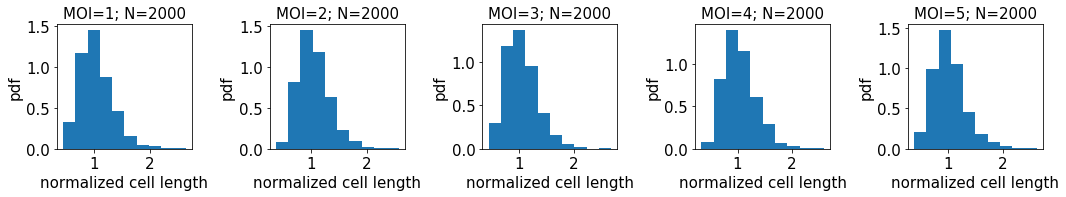

In [29]:
matplotlib.rcParams.update({"figure.figsize": (15,3)})
for i in range(1,6):
    subplot(1,5,i)
    hist(x_train[(i-1)*N:i*N,1],density=True)
    ylabel('pdf');xlabel('normalized cell length')
    title('MOI='+str(i)+'; N=2000')
tight_layout()

In [30]:
N = 2000;
n_moi = 5;
x_test = np.zeros((n_moi*N,2));
y_test = np.zeros(n_moi*N);
z_test = np.zeros(n_moi*N);

for m in range(6,11):
    l_list = np.random.lognormal(0, 0.28, N)
    x_test[(m-6)*N:(m-5)*N,0] = np.repeat(m,N);
    x_test[(m-6)*N:(m-5)*N,1] = l_list;
    p_list = cal_p(m,l_list,h,K);
    y_test[(m-6)*N:(m-5)*N] = Bernoulli(np.random.uniform(0,1,N),p_list);
    z_test[(m-6)*N:(m-5)*N] = p_list;
     

In [29]:
#x_train1 = tf.keras.utils.normalize(x_train, axis=1)
#x_test1 = tf.keras.utils.normalize(x_test, axis=1)

# 3 Perform training

## test single hidden layer with different number of nodes

In [104]:
x_train2 = x_train
y_train2 = y_train
p_diff1 = np.zeros(len(range(5,200)))
p_diff2 = np.zeros(len(range(5,200)))
j = 0;
for i in range(5,200):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(i, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 
    es_callback = tf.keras.callbacks.ModelCheckpoint('best_weight.hdf5',
                                                     monitor="val_loss",
                                                     verbose=0,
                                                     save_best_only=True,)
#    history = model.fit(x_train2, y_train2, validation_split=0.1, shuffle=True, epochs=10,verbose=0)
    history = model.fit(x_train2, y_train2, validation_split=0.1,shuffle=True,epochs=20,verbose=0, callbacks=[es_callback])
    model.load_weights('best_weight.hdf5')
    p_diff1[j] = np.mean(abs(model.predict(x_train2).flatten()-z_train))
    p_diff2[j] = np.mean(abs(model.predict(x_test).flatten()-z_test))
    j += 1;
np.savetxt('v2_diff1.txt',p_diff1, delimiter=",")
np.savetxt('v2_diff2.txt',p_diff2, delimiter=",")

(0, 0.12)

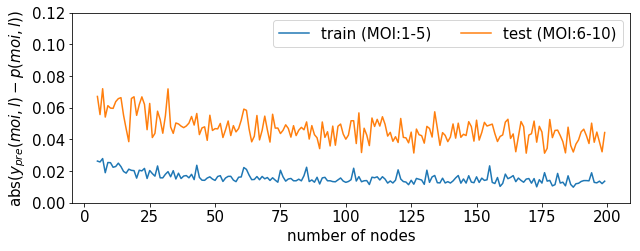

In [107]:
p_diff1 = np.genfromtxt('v2_diff1.txt',delimiter=',')
p_diff2 = np.genfromtxt('v2_diff2.txt',delimiter=',')

matplotlib.rcParams.update({"figure.figsize": (10,3.5)})
plot(range(5,200),p_diff1,label='train (MOI:1-5)')
plot(range(5,200),p_diff2,label='test (MOI:6-10)')
legend(ncol=2,loc='upper right')
xlabel('number of nodes')
ylabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
ylim(0,0.12)

In [110]:
x_train2 = x_train
y_train2 = y_train
p_diff1 = np.zeros(len(range(1,5)))
p_diff2 = np.zeros(len(range(1,5)))
j = 0;
for i in range(1,5):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(i, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 
    es_callback = tf.keras.callbacks.ModelCheckpoint('best_weight.hdf5',
                                                     monitor="val_loss",
                                                     verbose=0,
                                                     save_best_only=True,)
#    history = model.fit(x_train2, y_train2, validation_split=0.1, shuffle=True, epochs=10,verbose=0)
    history = model.fit(x_train2, y_train2, validation_split=0.1,shuffle=True,epochs=20,verbose=0, callbacks=[es_callback])
    model.load_weights('best_weight.hdf5')
    p_diff1[j] = np.mean(abs(model.predict(x_train2).flatten()-z_train))
    p_diff2[j] = np.mean(abs(model.predict(x_test).flatten()-z_test))
    j += 1;
np.savetxt('v1_diff1.txt',p_diff1, delimiter=",")
np.savetxt('v1_diff2.txt',p_diff2, delimiter=",")


## minimum network size is 5

(0, 0.2)

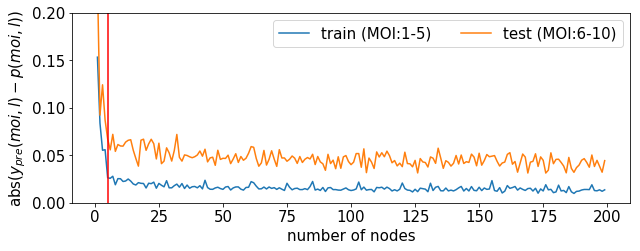

In [114]:
p_diff10 = np.genfromtxt('v1_diff1.txt',delimiter=',')
p_diff20 = np.genfromtxt('v1_diff2.txt',delimiter=',')
p_diff11 = np.genfromtxt('v2_diff1.txt',delimiter=',')
p_diff21 = np.genfromtxt('v2_diff2.txt',delimiter=',')
p_diff1 = np.append(p_diff10,p_diff11)
p_diff2 = np.append(p_diff20,p_diff21)

matplotlib.rcParams.update({"figure.figsize": (10,3.5)})
plot(range(1,200),p_diff1,label='train (MOI:1-5)')
plot(range(1,200),p_diff2,label='test (MOI:6-10)')
axvline(5,color = 'red')
legend(ncol=2,loc='upper right')
xlabel('number of nodes')
ylabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
ylim(0,0.20)

# 4 Comparision to ZL2010 model
## 4.1 predicting probablity of lysogeny based on MOI

In [31]:
def Hill_equation(x,h,K):
    return x**h/(K**h+x**h)
Hill_equation = np.vectorize(Hill_equation)

def Hill_fit(xx,y):
    popt, pcov = curve_fit(Hill_equation, xx, y, p0=[1,1])
    return (popt[0],popt[1])

In [49]:
np.random.seed(3)
import keras

x_train2 = x_train
y_train2 = y_train

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5, activation=tf.nn.relu,input_shape=(2,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 
es_callback = tf.keras.callbacks.ModelCheckpoint('best_weight_5N.hdf5',
                                                     monitor="val_loss",
                                                     verbose=0,
                                                     save_best_only=True,)
history = model.fit(x_train2, y_train2, validation_split=0.1,shuffle=True,epochs=20,verbose=0, callbacks=[es_callback])
model.load_weights('best_weight_5N.hdf5')

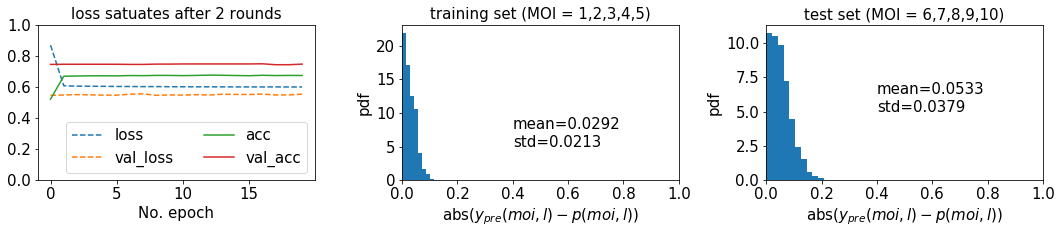

In [50]:
p_diff1 = abs(model.predict(x_train2).flatten()-z_train)
p_diff2 = abs(model.predict(x_test).flatten()-z_test)

matplotlib.rcParams.update({"figure.figsize": (15,3.5)})
subplot(1,3,1)
plt.plot(history.history['loss'],'--', label='loss')
plt.plot(history.history['val_loss'],'--', label='val_loss')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('loss satuates after 2 rounds')
#plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right",ncol=2)
ylim(0,1)
tight_layout()

subplot(1,3,2)
title('training set (MOI = 1,2,3,4,5)')
hist(p_diff1,density=True)
ylabel('pdf');xlabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
xlim((0,1))
text(0.4,5,'mean='+str(round(np.mean(p_diff1),4))+'\n'+'std='+str(round(np.std(p_diff1),4)))

subplot(1,3,3)
title('test set (MOI = 6,7,8,9,10)')
hist(p_diff2,density=True)
ylabel('pdf');xlabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
xlim((0,1))
text(0.4,5,'mean='+str(round(np.mean(p_diff2),4))+'\n'+'std='+str(round(np.std(p_diff2),4)))

tight_layout()


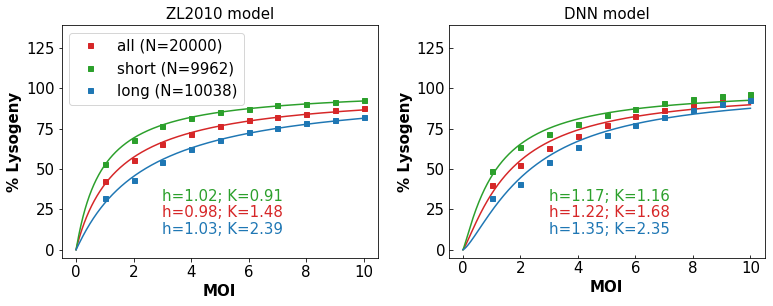

In [51]:
#model.save('DNN_5N')
#model = keras.models.load_model("DNN_5N")

N_a = 0; N_s = 0; N_l = 0;  #counts

p_m = np.zeros((10,3)); p_e = np.zeros((10,3)); h_ = np.zeros(10); K_ = np.zeros(10)
p_m2 = np.zeros((10,3)); p_e2 = np.zeros((10,3)); h_2 = np.zeros(10); K_2 = np.zeros(10)

l_all = np.zeros((11,2000)) #lengths

for m in range(1,11):
    l_list = np.random.lognormal(0, 0.28, 2000)
    l_all[m,:] = l_list; 
    l_long = l_list[l_list>1.0]; N_l += len(l_long);
    l_short = l_list[l_list<=1.0]; N_s += len(l_short);
    m_long = np.repeat(m,len(l_long)); x_long = np.vstack((m_long,l_long)).T; 
    m_short = np.repeat(m,len(l_short)); x_short = np.vstack((m_short, l_short)).T
    m_all = np.repeat(m, 2000); x_all = np.vstack((m_all, l_list)).T
    
    t_a = model.predict(x_all).flatten()
    t_s = model.predict(x_short).flatten()
    t_l = model.predict(x_long).flatten()

    p_m[m-1,0] = np.mean(t_a); #p_e[m-1,0] = np.std(t_a);
    p_m[m-1,1] = np.mean(t_s); #p_e[m-1,1] = np.std(t_s);
    p_m[m-1,2] = np.mean(t_l); #p_e[m-1,2] = np.std(t_l);
    
    p_m2[m-1,0] = np.mean(cal_p(m,l_list,h,K));
    p_m2[m-1,1] = np.mean(cal_p(m,l_short,h,K));
    p_m2[m-1,2] = np.mean(cal_p(m,l_long,h,K));
    
N_a = N_s + N_l
xx = np.array(range(0,11))
(h_[0], K_[0]) = Hill_fit(xx[1:],p_m[:,0])
(h_[1], K_[1]) = Hill_fit(xx[1:],p_m[:,1])
(h_[2], K_[2]) = Hill_fit(xx[1:],p_m[:,2])

(h_2[0], K_2[0]) = Hill_fit(xx[1:],p_m2[:,0])
(h_2[1], K_2[1]) = Hill_fit(xx[1:],p_m2[:,1])
(h_2[2], K_2[2]) = Hill_fit(xx[1:],p_m2[:,2])


xxx = np.linspace(0,10,1000)
##################plot####################
matplotlib.rcParams.update({"figure.figsize": (11,4.5)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plotStyles={"markersize":5,"markeredgewidth":1.0,"linewidth":2.0}

colors = ['tab:red','tab:green','tab:blue']
N_ = [N_a, N_s, N_l];
label_ = ['all','short','long']
y_loc = [20,30,10]

subplot(1,2,1)
title('ZL2010 model')
for i in range(0,3):
    plot(xx[1:],p_m2[:,i]*100, 's',color=colors[i],label=label_[i]+' (N='+str(N_[i])+')',**plotStyles)
    plot(xxx,Hill_equation(xxx,h_2[i],K_2[i])*100,'-',color=colors[i])
    text(3,y_loc[i],'h='+str(round(h_2[i],2))+'; K='+str(round(K_2[i],2)),color=colors[i])

legend(loc='upper left')
ylim((-5,139))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')

subplot(1,2,2)
title('DNN model')
for i in range(0,3):
    plot(xx[1:],p_m[:,i]*100, 's',color=colors[i],label=label_[i]+' (N='+str(N_[i])+')',**plotStyles)
    plot(xxx,Hill_equation(xxx,h_[i],K_[i])*100,'-',color=colors[i])
    text(3,y_loc[i],'h='+str(round(h_[i],2))+'; K='+str(round(K_[i],2)),color=colors[i])

#legend(loc='upper left')
ylim((-5,139))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')


tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
tight_layout()

#plt.savefig('file_virtual_phage/rre_fig2c.png')
#plt.close()

#display(HTML("<table><tr><td><img src='file_virtual_phage/rre_fig2c.png' width=380></td><td><img src='files/fig2c.png' width=450></td></tr></table>"))
        

## 4.2 predicting probablity of lysogeny based on viral concerntration

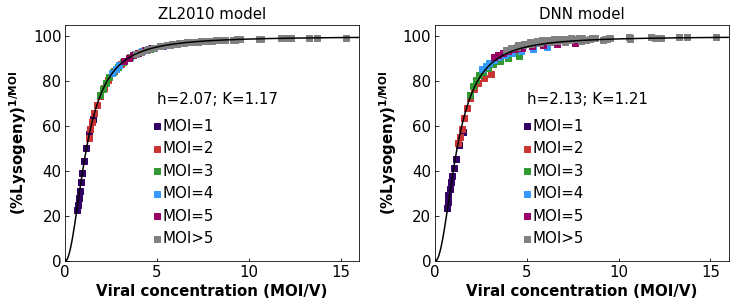

In [52]:
colors = ['#330066','#CC3333','#339933','#3399FF','#990066','grey','grey','grey','grey','grey']

bin_l = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
bin_h = [0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6]

x_ = np.array([]); x_m = np.empty((10,),dtype=object)
y_1 = np.array([]); y_m1 = np.empty((10,),dtype=object)
y_2 = np.array([]); y_m2 = np.empty((10,),dtype=object)

for m in range(1,11):
    my_l = np.array(l_all[m,:]);
    x_list = np.array([])
    tmp1 = np.array([])
    tmp2 = np.array([])
    for i in range(0,len(bin_l)):
        indices1 = np.where(my_l>=bin_l[i])[0]
        indices2 = np.where(my_l<bin_h[i])[0]
        indices = list(set(indices1) & set(indices2))
        length = my_l[indices]
        moi = np.repeat(m,len(length))
        x_list = np.append(x_list, m/np.mean(my_l[indices]))
        tmp1 = np.append(tmp1, np.mean(model.predict(np.vstack((moi,length)).T).flatten())**(1/m))
        tmp2 = np.append(tmp2, np.mean(cal_p(m,length,h,K))**(1/m));
    x_ = np.append(x_, x_list);
    y_1 = np.append(y_1, tmp1);
    y_2 = np.append(y_2, tmp2);
    x_m[m-1] = x_list;
    y_m1[m-1] = tmp1;
    y_m2[m-1] = tmp2;

(h1,K1) = Hill_fit(x_,y_1)
(h2,K2) = Hill_fit(x_,y_2)

matplotlib.rcParams.update({"figure.figsize": (10.5,4.5)})
subplot(1,2,1)
title('ZL2010 model')
xx = np.linspace(0,16,1000)
for i in range(0,10):
    plot(x_m[i], y_m2[i]*100, 's', color=colors[i])
plot(xx,Hill_equation(xx,h2,K2)*100,color='black')
xlim((0,16));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
text(5,70,'h='+str(round(h2,2))+'; K='+str(round(K2,2)),color='black')
plot(5,60,'s',color=colors[0]); text(5.3,58,'MOI=1')
plot(5,50,'s',color=colors[1]); text(5.3,48,'MOI=2')
plot(5,40,'s',color=colors[2]); text(5.3,38,'MOI=3')
plot(5,30,'s',color=colors[3]); text(5.3,28,'MOI=4')
plot(5,20,'s',color=colors[4]); text(5.3,18,'MOI=5')
plot(5,10,'s',color=colors[5]); text(5.3,8,'MOI>5')

subplot(1,2,2)
title('DNN model')
xx = np.linspace(0,16,1000)
for i in range(0,10):
    plot(x_m[i], y_m1[i]*100, 's', color=colors[i])
plot(xx,Hill_equation(xx,h1,K1)*100,color='black')
xlim((0,16));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
text(5,70,'h='+str(round(h1,2))+'; K='+str(round(K1,2)),color='black')
plot(5,60,'s',color=colors[0]); text(5.3,58,'MOI=1')
plot(5,50,'s',color=colors[1]); text(5.3,48,'MOI=2')
plot(5,40,'s',color=colors[2]); text(5.3,38,'MOI=3')
plot(5,30,'s',color=colors[3]); text(5.3,28,'MOI=4')
plot(5,20,'s',color=colors[4]); text(5.3,18,'MOI=5')
plot(5,10,'s',color=colors[5]); text(5.3,8,'MOI>5')

tight_layout() 

#plt.savefig('files/re_fig3c.png')
#plt.close()

# 5 interpretation

/miniconda3/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


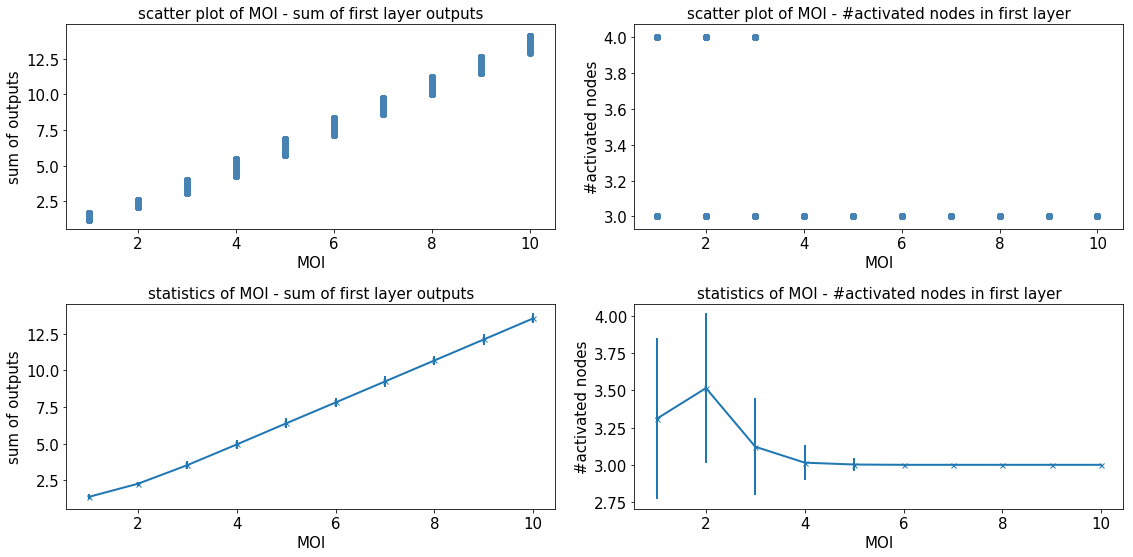

In [53]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

x_all = np.vstack((x_train,x_test))


layer_outs = [func([x_all, 1.]) for func in functors]

bin_l = np.arange(0.6,1.6,0.1)
bin_h = np.arange(0.7,1.7,0.1)
bin_m = np.arange(0.65,1.65,0.1)

my_y1 = np.zeros((10,2))
my_y2 = np.zeros((10,2))

matplotlib.rcParams.update({"figure.figsize": (16,8)})
for j in range(0,10):
    my_nonzero = np.zeros(2000)
    my_moi = np.zeros(2000)
    my_len = np.zeros(2000)
    my_sum = np.zeros(2000)
    for i in range(0,2000):
        tmp = layer_outs[0][0][i+j*2000]
        my_nonzero[i] = len(tmp[tmp>0])
        my_sum[i] = np.sum(tmp)
        my_moi[i] = x_all[i+j*2000,0]
        my_len[i] = x_all[i+j*2000,1]
        
    my_y1[j,:] = [np.mean(my_sum), np.std(my_sum)]
    my_y2[j,:] = [np.mean(my_nonzero), np.std(my_nonzero)]
    
    for ii in range(0,len(bin_l)):
        indices1 = np.where(my_len>=bin_l[ii])[0]
        indices2 = np.where(my_len<bin_h[ii])[0]
        indices = list(set(indices1) & set(indices2))
        
        subplot(2,2,1)
        title('scatter plot of MOI - sum of first layer outputs')
        scatter(my_moi[indices], my_sum[indices],color='steelblue')
        xlabel('MOI'); ylabel('sum of outputs')
    
        subplot(2,2,2)
        title('scatter plot of MOI - #activated nodes in first layer')
        scatter(my_moi[indices],my_nonzero[indices],color='steelblue')
        xlabel('MOI'); ylabel('#activated nodes')
    #    xlim(0,11); ylim(0,8)
#        if (j==9):
#            legend(ncol=5,title='len', loc='best')

subplot(2,2,3)
title('statistics of MOI - sum of first layer outputs')
errorbar(range(1,11),my_y1[:,0],yerr=my_y1[:,1],fmt='x-',**plotStyles)
xlabel('MOI'); ylabel('sum of outputs')
#xlim(0,11); ylim(0,22)

subplot(2,2,4)
title('statistics of MOI - #activated nodes in first layer')
errorbar(range(1,11),my_y2[:,0],yerr=my_y2[:,1],fmt='x-', **plotStyles)
xlabel('MOI'); ylabel('#activated nodes')
#xlim(0,11); ylim(0,8)
    
tight_layout()

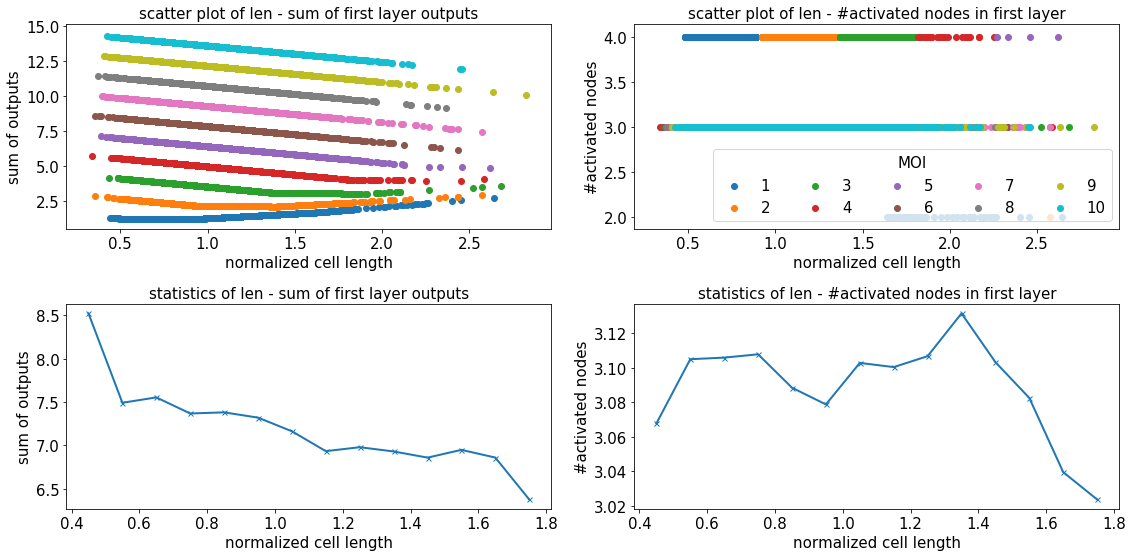

In [58]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

x_all = np.vstack((x_train,x_test))

layer_outs = [func([x_all, 1.]) for func in functors]

bin_l = np.arange(0,  1.8, 0.1)
bin_h = np.arange(0.1,1.9, 0.1)
bin_m = np.arange(0.05,1.85,0.1)

len_bin = len(bin_l)
y_1 = np.zeros((len_bin,10))
y_2 = np.zeros((len_bin,10))
w = np.zeros((len_bin,10))

matplotlib.rcParams.update({"figure.figsize": (16,8)})
for j in range(0,10):
    my_nonzero = np.zeros(2000)
    my_moi = np.zeros(2000)
    my_len = np.zeros(2000)
    my_sum = np.zeros(2000)
    for i in range(0,2000):
        tmp = layer_outs[0][0][i+j*2000]
        my_nonzero[i] = len(tmp[tmp>0])
        my_sum[i] = np.sum(tmp)
        my_moi[i] = x_all[i+j*2000,0]
        my_len[i] = x_all[i+j*2000,1]
    for ii in range(0,len(bin_l)):
        indices1 = np.where(my_len>=bin_l[ii])[0]
        indices2 = np.where(my_len<bin_h[ii])[0]
        indices = list(set(indices1) & set(indices2))
        y_1[ii,j] = np.mean(my_sum[indices])
        y_2[ii,j] = np.mean(my_nonzero[indices])
        w[ii,j] = len(indices)
        
    subplot(2,2,1)
    title('scatter plot of len - sum of first layer outputs')
    scatter(my_len, my_sum,label='MOI='+str(j+1))
    xlabel('normalized cell length'); ylabel('sum of outputs')
#    xlim(0,11); ylim(0,22)
#    legend(ncol=2,loc='upper left')
    
    subplot(2,2,2)
    title('scatter plot of len - #activated nodes in first layer')
    scatter(my_len,my_nonzero,label=str(j+1))
#    scatter(np.mean(my_moi),np.mean(my_sum/my_nonzero),label='MOI='+str(j+1))
    xlabel('normalized cell length'); ylabel('#activated nodes')
#    xlim(0,11); ylim(0,8)
    legend(ncol=5,title='MOI', loc='lower right')

my_y1 = np.zeros(len_bin)
my_y2 = np.zeros(len_bin)

for ii in range(0,len(bin_l)): 
    s1 = 0;
    s2 = 0;
    for j in range(0,10):
        s1 += y_1[ii,j]*w[ii,j]
        s2 += y_2[ii,j]*w[ii,j]
    my_y1[ii] = s1/np.sum(w[ii,:])
    my_y2[ii] = s2/np.sum(w[ii,:])
    
subplot(2,2,3)
title('statistics of len - sum of first layer outputs')
plot(bin_m,my_y1,'x-',**plotStyles)
xlabel('normalized cell length'); ylabel('sum of outputs')
#xlim(0,11); ylim(0,22)

subplot(2,2,4)
title('statistics of len - #activated nodes in first layer')
plot(bin_m,my_y2,'x-', **plotStyles)
xlabel('normalized cell length'); ylabel('#activated nodes')
#xlim(0,11); ylim(0,8)
    
tight_layout()

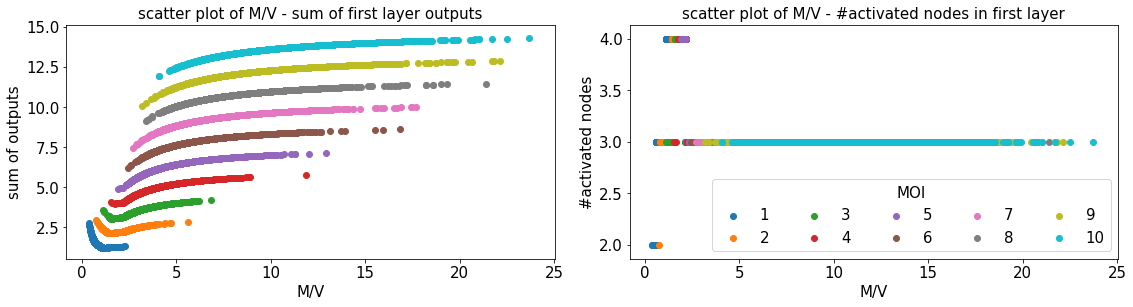

In [82]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

x_all = np.vstack((x_train,x_test))

layer_outs = [func([x_all, 1.]) for func in functors]

bin_l = np.arange(0,  1.8, 0.1)
bin_h = np.arange(0.1,1.9, 0.1)
bin_m = np.arange(0.05,1.85,0.1)

len_bin = len(bin_l)
y_1 = np.zeros((len_bin,10))
y_2 = np.zeros((len_bin,10))
w = np.zeros((len_bin,10))

matplotlib.rcParams.update({"figure.figsize": (16,8)})
for j in range(0,10):
    my_nonzero = np.zeros(2000)
    my_moi = np.zeros(2000)
    my_len = np.zeros(2000)
    my_sum = np.zeros(2000)
    for i in range(0,2000):
        tmp = layer_outs[0][0][i+j*2000]
        my_nonzero[i] = len(tmp[tmp>0])
        my_sum[i] = np.sum(tmp)
        my_moi[i] = x_all[i+j*2000,0]
        my_len[i] = x_all[i+j*2000,1]
    for ii in range(0,len(bin_l)):
        indices1 = np.where(my_len>=bin_l[ii])[0]
        indices2 = np.where(my_len<bin_h[ii])[0]
        indices = list(set(indices1) & set(indices2))
        y_1[ii,j] = np.mean(my_sum[indices])
        y_2[ii,j] = np.mean(my_nonzero[indices])
        w[ii,j] = len(indices)
        
    subplot(2,2,1)
    title('scatter plot of M/V - sum of first layer outputs')
    scatter(my_moi/my_len, my_sum,label='MOI='+str(j+1))
    xlabel('M/V'); ylabel('sum of outputs')
#    xlim(0,11); ylim(0,22)
#    legend(ncol=2,loc='upper left')
    
    subplot(2,2,2)
    title('scatter plot of M/V - #activated nodes in first layer')
    scatter(my_moi/my_len,my_nonzero,label=str(j+1))
#    scatter(np.mean(my_moi),np.mean(my_sum/my_nonzero),label='MOI='+str(j+1))
    xlabel('M/V'); ylabel('#activated nodes')
#    xlim(0,11); ylim(0,8)
    legend(ncol=5,title='MOI', loc='lower right')

    
tight_layout()

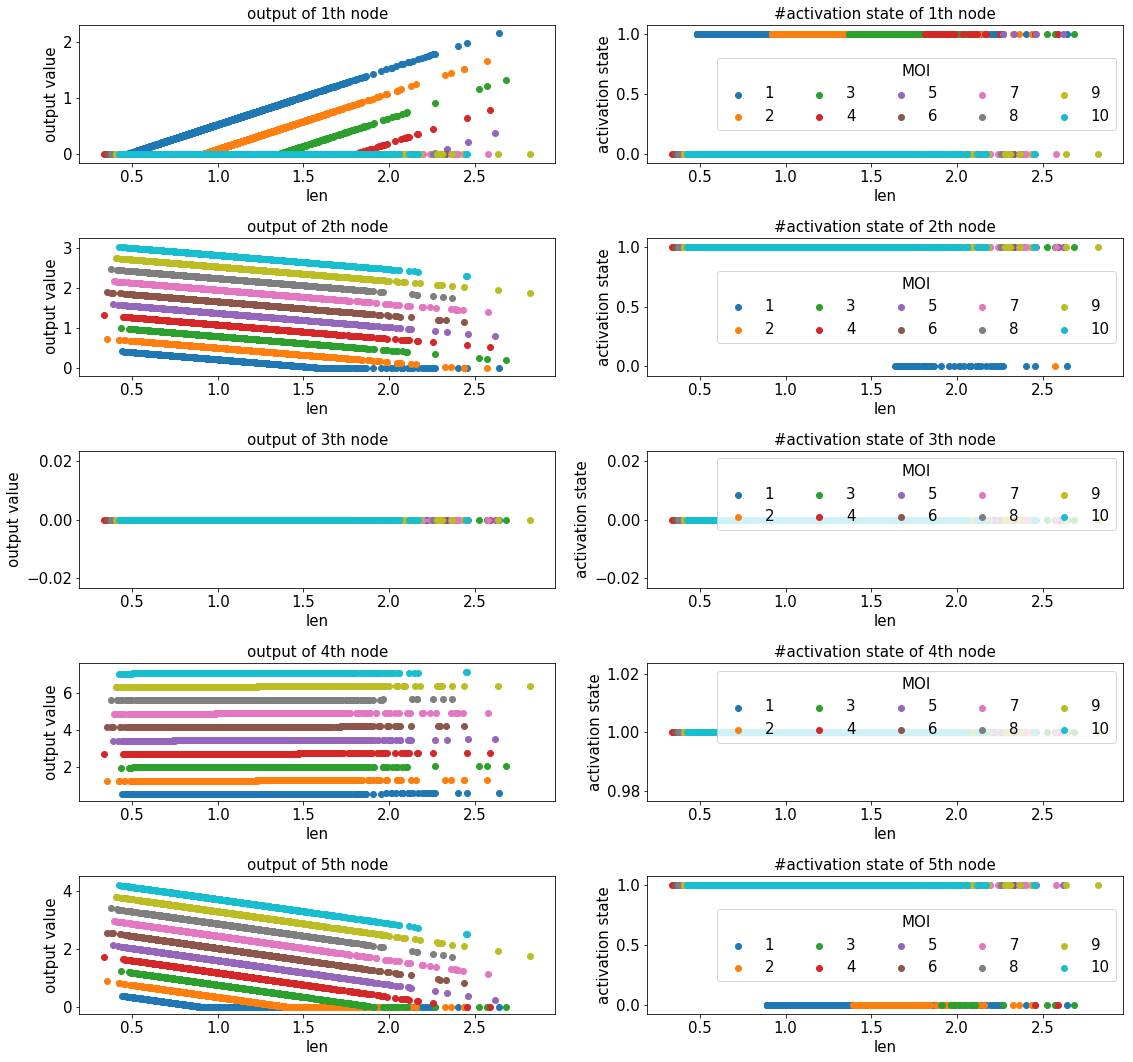

In [83]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

x_all = np.vstack((x_train,x_test))


layer_outs = [func([x_all, 1.]) for func in functors]

my_y1 = np.zeros((5,2))
my_y2 = np.zeros((5,2))

matplotlib.rcParams.update({"figure.figsize": (16,15)})
for j in range(0,10):
    my_nonzero = np.zeros((2000,8))
    my_moi = np.zeros((2000,8))
    my_len = np.zeros((2000,8))
    my_sum = np.zeros((2000,8))
    for i in range(0,2000):
        tmp0 = layer_outs[0][0][i+j*2000]
        for k in range(0,5):
            tmp = tmp0[k]
            my_nonzero[i,k] = len(tmp[tmp>0])
            my_sum[i,k] = np.sum(tmp)
            my_moi[i,k] = x_all[i+j*2000,0]
            my_len[i,k] = x_all[i+j*2000,1]
#    my_y1[j,:] = [np.mean(my_sum), np.std(my_sum)]
#    my_y2[j,:] = [np.mean(my_nonzero), np.std(my_nonzero)]
    for k in range(0,5):
        subplot(5,2,1+k*2)
        title('output of '+str(k+1)+'th node')
        scatter(my_len[:,k], my_sum[:,k],label='MOI='+str(j+1))
        xlabel('len'); ylabel('output value')
        
        subplot(5,2,2+k*2)
        title('#activation state of '+str(k+1)+'th node')
        scatter(my_len[:,k],my_nonzero[:,k],label=str(j+1))
        xlabel('len'); ylabel('activation state')
        legend(ncol=5,title='MOI', loc='best')

tight_layout()

/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars
/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


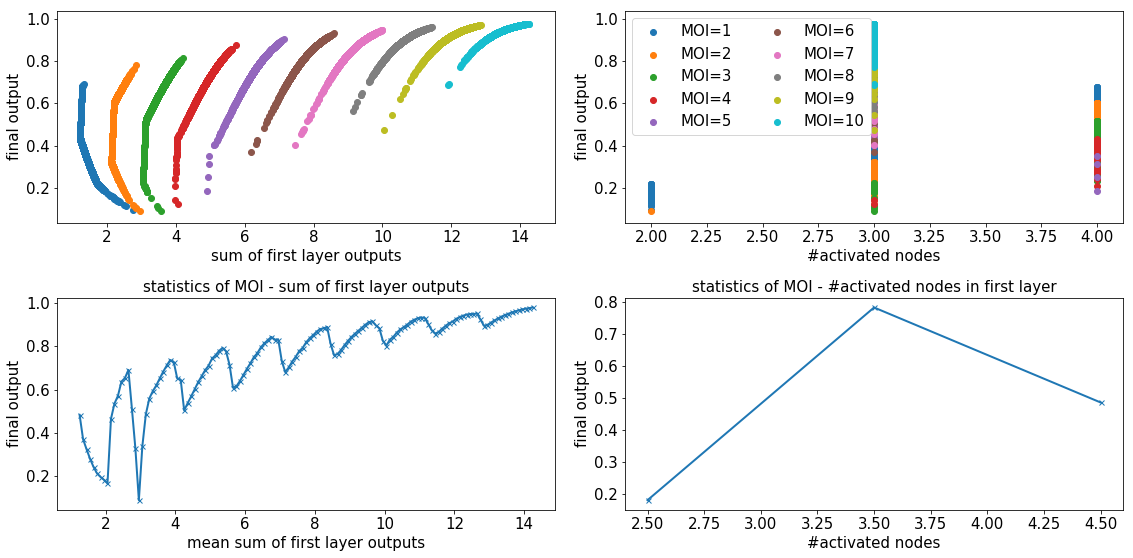

In [81]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

x_all = np.vstack((x_train,x_test))


layer_outs = [func([x_all, 1.]) for func in functors]


bin__l = np.arange(0,15,0.1);
bin__h = np.arange(0.1,15.1,0.1);
bin__m = np.arange(0.05,15.05,0.1);

my_y1 = np.zeros((len(bin__l),10))
weight1 = np.zeros((len(bin__l),10))

node_l = np.arange(0, 10,1);
node_h = np.arange(1,11,1);
node_m = np.arange(0.5,10.5,1);
my_y2 = np.zeros((len(node_m),10))
weight2 = np.zeros((len(node_m),10))


matplotlib.rcParams.update({"figure.figsize": (16,8)})
for j in range(0,10):
    my_nonzero = np.zeros(2000)
    my_final = np.zeros(2000)
    my_moi = np.zeros(2000)
    my_len = np.zeros(2000)
    my_sum = np.zeros(2000)
    for i in range(0,2000):
        tmp = layer_outs[0][0][i+j*2000]
        my_nonzero[i] = len(tmp[tmp>0])
        my_final[i] = layer_outs[1][0][i+j*2000]
        my_sum[i] = np.sum(tmp)
        my_moi[i] = x_all[i+j*2000,0]
        my_len[i] = x_all[i+j*2000,1]
    for kk in range(0,len(node_l)):
        indices1 = np.where(my_nonzero>=node_l[kk])[0]
        indices2 = np.where(my_nonzero<node_h[kk])[0]
        indices = list(set(indices1) & set(indices2))
        if (len(indices) == 0):
            my_y2[kk,j] = 0;
            weight2[kk,j] = 0;
        else:
            my_final0 = my_final[indices]
            weight2[kk,j] = len(my_final0)
            my_y2[kk,j] = np.mean(my_final0)
    for kk in range(0,len(bin__l)):
        indices1 = np.where(my_sum>=bin__l[kk])[0]
        indices2 = np.where(my_sum<bin__h[kk])[0]
        indices = list(set(indices1) & set(indices2))
        if (len(indices) == 0):
            my_y1[kk,j] = 0;
            weight1[kk,j] = 0;
        else:
            my_final0 = my_final[indices]
            my_y1[kk,j] = np.mean(my_final0)
            weight1[kk,j] = len(my_final0)
    
    subplot(2,2,1)
    scatter(my_sum,my_final,label='MOI='+str(j+1));
    xlabel('sum of first layer outputs'); ylabel('final output')
    
    subplot(2,2,2)
    scatter(my_nonzero,my_final,label='MOI='+str(j+1));
#    scatter(np.mean(my_nonzero*my_moi),np.mean(my_final),label='MOI='+str(j+1))
    xlabel('#activated nodes'); ylabel('final output')
    legend(ncol=2,loc='best')

my__y1 = np.zeros(len(bin__l))
my__y2 = np.zeros(len(node_l))

for kk in range(0,len(my__y1)):
    for j in range(0,10):
        my__y1[kk] +=  my_y1[kk,j]*weight1[kk,j]
    my__y1[kk] = my__y1[kk]/np.sum(weight1[kk,:])

for kk in range(0,len(my__y2)):
    for j in range(0,10):
        my__y2[kk] +=  my_y2[kk,j]*weight2[kk,j]
    my__y2[kk] = my__y2[kk]/np.sum(weight2[kk,:])
    
subplot(2,2,3)
title('statistics of MOI - sum of first layer outputs')
plot(bin__m, my__y1, 'x-', **plotStyles)
xlabel('mean sum of first layer outputs'); ylabel('final output')
#xlim(0,11); ylim(0,22)

subplot(2,2,4)
title('statistics of MOI - #activated nodes in first layer')
plot(node_m, my__y2, 'x-', **plotStyles)
xlabel('#activated nodes'); ylabel('final output')
#xlim(0,11); ylim(0,8)
    
tight_layout()